Automatic classification of stigmatizing mental illness articles in online news journals - April 2022
Author: Alina Yanchuk - alinayanchuk@ua.pt

### Table of contents:

* [3. Classification](#chapter3)
    * [3.1 Requirements](#section_3_1)
    * [3.2 Imports](#section_3_2)
    * [3.3 Get data](#section_3_3)
    * [3.4 Train and Test dataset](#section_3_4)
    * [3.5 Generate feature vectors](#section_3_5)
    * [3.6 Models training and optimization (Machine Learning)](#section_3_6)
        * [3.6.1 Logistics Regression](#section_3_6_1)
            * [3.6.1.1 With bag-of-words](#section_3_6_1_1)
            * [3.6.1.2 With TF-IDF](#section_3_6_1_2)
            * [3.6.1.3 With LIWC](#section_3_6_1_3)
        * [3.6.2 Linear Support Vector Classifier (SVC)](#section_3_6_2)
            * [3.6.2.1 With bag-of-words](#section_3_6_2_1)
            * [3.6.2.2 With TF-IDF](#section_3_6_2_2)
            * [3.6.2.3 With LIWC](#section_3_6_2_3)
        * [3.6.3 Multinomial Naive Bayes](#section_3_6_3)
            * [3.6.3.1 With bag-of-words](#section_3_6_3_1)
            * [3.6.3.2 With TF-IDF](#section_3_6_3_2)
            * [3.6.3.3 With LIWC](#section_3_6_3_3)
        * [3.6.4 K-Nearest Neighbors](#section_3_6_4)
            * [3.6.4.1 With bag-of-words](#section_3_6_4_1)
            * [3.6.4.2 With TF-IDF](#section_3_6_4_2)
            * [3.6.4.3 With LIWC](#section_3_6_4_3)
        * [3.6.5 Random Forest](#section_3_6_5)
            * [3.6.5.1 With bag-of-words](#section_3_6_5_1)
            * [3.6.5.2 With TF-IDF](#section_3_6_5_2)
            * [3.6.5.3 With LIWC](#section_3_6_5_3)
        * [3.6.6 XGBoost](#section_3_6_6)
            * [3.6.6.1 With bag-of-words](#section_3_6_6_1)
            * [3.6.6.2 With TF-IDF](#section_3_6_6_2)
            * [3.6.6.3 With LIWC](#section_3_6_6_3)
    * [3.7 Models training and optimization (Deep learning)](#section_3_7)
        * [3.7.1 Convolutional Neural Network](#section_3_7_1)
        * [3.7.2 Long Short-Term Memory (LSTM)](#section_3_7_2)
        * [3.7.3 Bidirectional Long Short-Term Memory (Bi-LSTM)](#section_3_7_3)
    * [3.8 Evaluation analysis](#section_3_8)

# 3. Classification <a class="anchor" id="chapter3"></a>

## 3.1 Requirements <a class="anchor" id="section_3_1"></a>

In [1]:
#pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#pip install scikit-optimize

In [ ]:
#pip install tensorflow 

In [ ]:
#pip install tensorflow-gpu 

In [40]:
#pip install keras-tuner

In [3]:
#pip install pydot
#pip install graphviz

     |████████████████████████████████| 46 kB 1.3 MB/s 
Note: you may need to restart the kernel to use updated packages.


In [11]:
#pip install tensorflow_hub

     |████████████████████████████████| 108 kB 3.2 MB/s 
Note: you may need to restart the kernel to use updated packages.


## 3.2 Imports <a class="anchor" id="section_3_2"></a>

In [1]:
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split

from math import floor, log

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from keras.preprocessing import text, sequence
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as scores

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, Flatten, MaxPooling1D, LSTM, Bidirectional

from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import cross_val_score
from skopt import gp_minimize
from skopt.utils import use_named_args

import keras_tuner as kt

from keras.utils.vis_utils import plot_model

2022-05-18 15:15:02.776934: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-18 15:15:02.776961: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/alina/anaconda3/envs/stigma/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 3.3 Get data <a class="anchor" id="section_3_3"></a>

In [2]:
data = pd.read_pickle('data_preprocessed.pkl')
data.head()

,label,content
0,0,prisão perpétua homem tentou assassinar senado...
1,0,john nash matemático mente brilhante morre aci...
2,1,mito reeleição mínima garantida cavaco sairá d...
3,0,morreu rita levintalcini grande dama ciência i...
4,0,trás porta amarela homem problemas psicológico...


## 3.4 Train and Test dataset <a class="anchor" id="section_3_4"></a>

In [3]:
# Divide the data into a 80% train dataset and 20% test dataset

X = data.loc[:,'content']
y = data.loc[:,'label']

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, data.index, test_size=0.2, random_state=55)

print("Number of news in train dataset: " + str(len(X_train)))
print("Number of news in train dataset: " + str(len(X_test)))

Number of news in train dataset: 782
Number of news in train dataset: 196


## 3.5 Generate feature vectors <a class="anchor" id="section_3_5"></a>

In [4]:
# Generate bag-of-words feature vectors

bow_vectorizer = CountVectorizer(lowercase=False)
bow_train = bow_vectorizer.fit_transform(X_train)
bow_test = bow_vectorizer.transform(X_test)

bow_train = (bow_train - np.min(bow_train)) / (np.max(bow_train) - np.min(bow_train)) # Normalize to range [0, 1]
bow_test = (bow_test - np.min(bow_test)) / (np.max(bow_test) - np.min(bow_test))

# (Number of news, Number of features/unique words in training dataset)
bow_train.shape

# IF SAVED - Load saved vectorizer
#bow_vectorizer = pickle.load(open("vectors/BOW.pickle", 'rb'))

(782, 44522)

In [5]:
# Generate TF-IDF feature vectors
# "words that are unique to particular document would have higher weights compared to words that are used commonly across documents"

tfidf_vectorizer = TfidfVectorizer(lowercase=False,)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

# (Number of news, Number of features/unique words in training dataset)
tfidf_train.shape

# IF SAVED - Load saved vectorizer
#tfidf_vectorizer = pickle.load(open("vectors/TFIDF.pickle", 'rb'))

(782, 44522)

In [6]:
# Generate LIWC-PT feature vectors
# "lexicon that assigns words to categories"
# http://143.107.183.175:21380/portlex/index.php/pt/projetos/liwc
# https://lit.eecs.umich.edu/geoliwc/liwc_dictionary.html

liwc_dictionary = {}
# IF SAVED - Load saved mapping
#liwc_dictionary = pickle.load(open("vectors/LIWC.pickle", 'rb'))


# Read the file and create the LIWC dictionary mapping (word-categories) (If not in repo, need to download from official website above)
with open("dictionary/liwc.txt", "r", encoding = "ISO-8859-1") as liwc_file:
    start = False
    for line in liwc_file:
        try:
            line = line.split()
            if start==False:
                if line[0]=="a":
                    start=True
                    word = line[0]
                    vector = np.asarray(line[1:], dtype='float32')
                    liwc_dictionary[word] = vector
            else:
                word = line[0]
                vector = np.asarray(line[1:], dtype='float32')
                liwc_dictionary[word] = vector
        except:
            pass

liwc_file.close()

# Create the feature vectors: each vector will have all the LIWC categories and the corresponding values will be incremented everytime a word in the news article (document) fits in that category

documents_train = list(X_train.values.flatten()) # List of all news
documents_train = [string.split() for string in documents_train] # Split each news article in tokens/words

liwc_train = np.zeros((len(X_train), 464))
for document in documents_train:
    i = documents_train.index(document)
    for word in document:
        if word in liwc_dictionary:
            vector = liwc_dictionary[word]
            for index in vector:
                liwc_train[i][int(index)-1] = liwc_train[i][int(index)-1] + 1

documents_test = list(X_test.values.flatten())
documents_test = [string.split() for string in documents_test]

liwc_test = np.zeros((len(X_test), 464))
for document in documents_test:
    i = documents_test.index(document)
    for word in document:
        if word in liwc_dictionary:
            vector = liwc_dictionary[word]
            for index in vector:
                liwc_test[i][int(index)-1] = liwc_test[i][int(index)-1] + 1

liwc_train = (liwc_train - np.min(liwc_train)) / (np.max(liwc_train) - np.min(liwc_train)) # Normalize to range [0, 1]
liwc_test = (liwc_test - np.min(liwc_test)) / (np.max(liwc_test) - np.min(liwc_test)) 

# (Number of news, Number of features/categories in training dataset)
liwc_train.shape

(782, 464)

In [30]:
# Generate Word Embeddings vectors and matrix
# Glove PT 300D from NILC-Embeddings 
# http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc

words_per_article = list(map(lambda x : len(x.split()),data.content))
avg = sum(words_per_article)/len(words_per_article) # Average number of words per news article
avg = pow(2, floor(log(avg)/log(2))) # Convert to nearest power of 2

results = Counter()
data['content'].str.lower().str.split().apply(results.update) # Number of unique words in all dataset

max_length_content = int(avg) # Max number of content that each object/news article will have after padding
vocabulary_length = len(results) # Max number of unique words

# Create word index
token = text.Tokenizer(lower=False, num_words=vocabulary_length) 
token.fit_on_texts(data['content']) # Tokenize all corpus
word_index = token.word_index # Index of unique words (dictionary)

# Convert text to sequence of tokens and pad them to ensure equal length vectors 
we_train = sequence.pad_sequences(token.texts_to_sequences(X_train), maxlen=max_length_content)
we_test = sequence.pad_sequences(token.texts_to_sequences(X_test), maxlen=max_length_content)

# Load the pre-trained word-embedding vectors (Glove 300D)
embedding_index = {}
# IF SAVED - Load saved mapping
#embedding_index = pickle.load(open("vectors/WE_glove.pickle", 'rb'))

# If not in repo, need to download from official website above
with open("pre-trained/glove_s300.txt", "r") as we_file:
    first_line = True
    for line in we_file:
        try:
            if first_line: # Ignore header
                first_line = False
            else:
                line = line.split()
                word = line[0]
                vector = np.asarray(line[1:], dtype='float32')
                embedding_index[word] = vector
        except:
            pass


# Create token-embedding mapping (with words from our dataset)
embedding_matrix = np.zeros((vocabulary_length, 300))
for word, i in word_index.items():
    if i > vocabulary_length - 1:
        break
    else:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

#(Number (vocabulary size) of features/unique words in all dataset, Number of dimensions/features)
embedding_matrix.shape

(51285, 300)

In [8]:
# Save feature vectorizers and mappings


with open('vectors/TFIDF.pickle', 'wb') as f1:
    pickle.dump(tfidf_vectorizer, f1)
f1.close()

with open('vectors/BOW.pickle', 'wb') as f2:
    pickle.dump(bow_vectorizer, f2)
f2.close()

with open('vectors/WE.pickle', 'wb') as f3:
    pickle.dump(embedding_index, f3)
f3.close()

with open('vectors/LIWC.pickle', 'wb') as f4:
    pickle.dump(liwc_dictionary, f4)
f4.close()


## 3.6 Models training and optimization (Machine Learning) <a class="anchor" id="section_3_6"></a>

#### Training

Attempt to get the best combination of weights and bias to the model to minimize the loss function over the prediction range and incrementally improve model's ability to predict the classes.

#### Optimization

Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes. They define how our model is actually structured. Hyper-parameter tuning is just an optimization loop on top of ML model learning to find the set of hyper-parameters leading to the lowest error on the validation set.

-  The optimization for the classic Machine Learning algorithms is performed with the K-fold cross (K=5) validation strategy, in order to essentially combine training and validation data for both learning the model parameters and evaluating the model without introducing data leakage.

    Library used -> Scikit-optimize: uses a Sequential model-based optimization algorithm to find optimal solutions for hyperparameter search problems in less time. 
    
    Reference: https://scikit-optimize.github.io/stable/auto_examples/hyperparameter-optimization.html

- Optimization for the Deep Learning algorithms:

    Library used -> Keras Tuner: The Hyperband algorithm is a variation of random search, but with some explore-exploit theory to find the best time allocation for each of the configurations.
    
    Reference: https://www.tensorflow.org/tutorials/keras/keras_tuner


In [43]:
# Create list to store evaluation metrics for all models

evaluation_metrics = []

# Function to store evaluation metrics for a model

def evaluation(evaluation_metrics_list, model, model_name, test_features, test_labels, feature_vectorizer_name, deep_learning=False):

    y_pred = model.predict(test_features)

    if deep_learning:
        y_pred = [int(round(p[0])) for p in y_pred]

    # Performance metrics
    accuracy = accuracy_score(test_labels, y_pred)*100

    # Precision, recall, f1 scores
    precision, recall, f1score, support = scores(y_test, y_pred, average='binary')

    # Add metrics to evaluation list
    evaluation_metrics_list.append(dict([
        ('Model', model_name),
        ('Feature Vectorizer', feature_vectorizer_name),
        ('Accuracy (%)', round(accuracy, 2)),
        ('Precision', round(precision, 3)),
        ('Recall', round(recall, 3)),
        ('F1', round(f1score, 3))
    ]))

    return evaluation_metrics_list

In [ ]:
# Function to predict labels (using the trained model) to a set of received features

def prediction(trained_model, features):

    y_pred = trained_model.predict(features)

    return y_pred

In [ ]:
# Function to insert predicted labels to original data's csv file

def insert(pred_labels, file_name):

    original_data = pd.read_pickle(file_name)

    original_data.insert(9, 'Predicted label', pred_labels)

    original_data.to_csv("result_" + file_name, index=False)

### 3.6.1 Logistic Regression <a class="anchor" id="section_2_6_1"></a>

- Is a classical linear method for binary classification (fits a line to best separate the two classes);
- It can handle both dense and sparse input;


#### 3.6.1.1 With bag-of-words <a class="anchor" id="section_3_6_1_1"></a>

In [33]:
# Model 

model_lr_bow = LogisticRegression(random_state=0) # solver: algorithm to use in the optimization problem (liblinear for small datasets)
#IF SAVED - Load saved model
#model_lr_bow = pickle.load(open("models/LogisticRegressionBOW.pickle", 'rb'))

# Hyper-parameteres tuning

space  = [Real(0, 32, name='C')] # Inverse of regularization strength

@use_named_args(space)
def objective(**params):
    model_lr_bow.set_params(**params)

    return -np.mean(cross_val_score(model_lr_bow, bow_train, y_train, cv=5, n_jobs=-1, scoring="neg_mean_absolute_error"))

res_gp = gp_minimize(objective, space, random_state=0)

best_C_lr_bow = res_gp.x[0]

print("""Best parameters: - C=%f""" % (best_C_lr_bow))

Best parameters: - C=27.016504


In [36]:
# Model training with BEST hyper-parameteres

model_lr_bow = LogisticRegression(random_state=0, C=best_C_lr_bow, solver="liblinear").fit(bow_train, y_train)

# Model saving
with open('models/LogisticRegressionBOW.pickle', 'wb') as f:
    pickle.dump(model_lr_bow, f)

# Store evaluation metrics
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_lr_bow, model_name="Logistic Regression", test_features=bow_test, test_labels=y_test, feature_vectorizer_name="Bag-of-words")

print("Logistic Regression (Bag-of-words) successfully trained and stored.")

Logistic Regression (Bag-of-words) successfully trained and stored.


#### 3.6.1.2 With TF-IDF <a class="anchor" id="section_3_6_1_2"></a>

In [37]:
# Model 

model_lr_tfidf = LogisticRegression(random_state=0)
# IF SAVED - Load saved model
#model_lr_tfidf = pickle.load(open("models/LogisticRegressionTFIDF.pickle", 'rb'))

# Hyper-parameteres tuning

space  = [Real(0, 32, name='C')] # Inverse of regularization strength

@use_named_args(space)
def objective(**params):
    model_lr_tfidf.set_params(**params)

    return -np.mean(cross_val_score(model_lr_tfidf, tfidf_train, y_train, cv=5, n_jobs=-1, scoring="neg_mean_absolute_error"))

res_gp = gp_minimize(objective, space, random_state=0)

best_C_lr_tfidf = res_gp.x[0]

print("""Best parameters: - C=%f""" % (best_C_lr_tfidf))

Best parameters: - C=4.014207


In [38]:
# Model training with BEST hyper-parameteres

model_lr_tfidf = LogisticRegression(random_state=0, C=best_C_lr_tfidf, solver="liblinear").fit(tfidf_train, y_train)

# Model saving
with open('models/LogisticRegressionTFIDF.pickle', 'wb') as f:
    pickle.dump(model_lr_tfidf, f)

# Store evaluation metrics
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_lr_tfidf, model_name="Logistic Regression", test_features=tfidf_test, test_labels=y_test, feature_vectorizer_name="TF-IDF")

print("Logistic Regression (TF-IDF) sucessfully trained and stored.")

Logistic Regression (TF-IDF) sucessfully trained and stored.


#### 3.6.1.3 With LIWC <a class="anchor" id="section_3_6_1_3"></a>

In [39]:
# Model 

model_lr_liwc = LogisticRegression(random_state=0)
# IF SAVED - Load saved model
#model_lr_LIWC = pickle.load(open("models/LogisticRegressionLIWC.pickle", 'rb'))

# Hyper-parameteres tuning

space  = [Real(0, 32, name='C')] # Inverse of regularization strength

@use_named_args(space)
def objective(**params):
    model_lr_liwc.set_params(**params)

    return -np.mean(cross_val_score(model_lr_liwc, liwc_train, y_train, cv=5, n_jobs=-1, scoring="neg_mean_absolute_error"))

res_gp = gp_minimize(objective, space, random_state=0)

best_C_lr_liwc = res_gp.x[0]

print("""Best parameters: - C=%f""" % (best_C_lr_liwc))

/home/alina/anaconda3/envs/stigma/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/alina/anaconda3/envs/stigma/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best parameters: - C=32.000000


In [40]:
# Model training with BEST hyper-parameteres

model_lr_liwc = LogisticRegression(random_state=0, C=best_C_lr_liwc, solver="liblinear").fit(liwc_train, y_train)

# Model saving
with open('models/LogisticRegressionLIWC.pickle', 'wb') as f:
    pickle.dump(model_lr_liwc, f)

# Store evaluation metrics
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_lr_liwc, model_name="Logistic Regression", test_features=liwc_test, test_labels=y_test, feature_vectorizer_name="LIWC")

print("Logistic Regression (LIWC) sucessfully trained and stored.")

Logistic Regression (LIWC) sucessfully trained and stored.


### 3.6.2 Linear Support Vector Classifier (SVC) <a class="anchor" id="section_3_6_2"></a>

 - Supports both dense and sparse input 

#### 3.6.2.1 With bag-of-words <a class="anchor" id="section_3_6_2_1"></a>

In [41]:
# Model

model_svc_bow = LinearSVC(random_state=0)
# IF SAVED - Load saved model
#model_svc_bow = pickle.load(open("models/LinearSVCBOW.pickle", 'rb'))

# Hyper-parameteres tuning

space  = [Real(0, 32, name='C')] # Inverse of regularization strength

@use_named_args(space)
def objective(**params):
    model_svc_bow.set_params(**params)

    return -np.mean(cross_val_score(model_svc_bow, bow_train, y_train, cv=5, n_jobs=-1, scoring="neg_mean_absolute_error"))

res_gp = gp_minimize(objective, space, random_state=0)

best_C_svc_bow = res_gp.x[0]

print("""Best parameters: - C=%f""" % (best_C_svc_bow))

Best parameters: - C=12.300215


In [42]:
# Model training with BEST hyper-parameteres

model_svc_bow = LinearSVC(random_state=0, C=best_C_svc_bow).fit(bow_train, y_train)

# Model saving
with open('models/LinearSVCBOW.pickle', 'wb') as f:
    pickle.dump(model_svc_bow, f)

# Store evaluation metrics
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_svc_bow, model_name="Support Vector Classifier (Linear)", test_features=bow_test, test_labels=y_test, feature_vectorizer_name="Bag-of-words")

print("Linear Suppport Vector Classifier (Bag-of-words) successfully trained and stored.")

Linear Suppport Vector Classifier (Bag-of-words) successfully trained and stored.


#### 3.6.2.2 With TF-IDF <a class="anchor" id="section_3_6_2_2"></a>

In [19]:
# Model

model_svc_tfidf = LinearSVC(random_state=0)
# IF SAVED - Load saved model
#model_svc_tfidf = pickle.load(open("models/LinearSVCTFIDF.pickle", 'rb'))

# Hyper-parameteres tuning

space  = [Real(0, 32, name='C')] # Inverse of regularization strength

@use_named_args(space)
def objective(**params):
    model_svc_tfidf.set_params(**params)

    return -np.mean(cross_val_score(model_svc_tfidf, tfidf_train, y_train, cv=5, n_jobs=-1, scoring="neg_mean_absolute_error"))

res_gp = gp_minimize(objective, space, random_state=0)

best_C_svc_tfidf = res_gp.x[0]

print("""Best parameters: - C=%f""" % (best_C_svc_tfidf))

Best parameters: - C=9.299825


In [12]:
# Model training with BEST hyper-parameteres

model_svc_tfidf = LinearSVC(random_state=0, C=best_C_svc_tfidf).fit(tfidf_train, y_train)

# Model saving
with open('models/LinearSVCTFIDF.pickle', 'wb') as f:
    pickle.dump(model_svc_tfidf, f)

# Store evaluation metrics
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_svc_tfidf, model_name="Support Vector Classifier (Linear)", test_features=tfidf_test, test_labels=y_test, feature_vectorizer_name="TF-IDF")

print("Linear Support Vector Classifier (TF-IDF) sucessfully trained and stored.")

Linear Support Vector Classifier (TF-IDF) sucessfully trained and stored.


#### 3.6.2.4 With LIWC <a class="anchor" id="section_3_6_2_3"></a>

In [21]:
# Model

model_svc_liwc = LinearSVC(random_state=0)
# IF SAVED - Load saved model
#model_svc_liwc = pickle.load(open("models/LinearSVCLIWC.pickle", 'rb'))

# Hyper-parameteres tuning

space  = [Real(0, 32, name='C')] # Inverse of regularization strength

@use_named_args(space)
def objective(**params):
    model_svc_liwc.set_params(**params)

    return -np.mean(cross_val_score(model_svc_liwc, liwc_train, y_train, cv=5, n_jobs=-1, scoring="neg_mean_absolute_error"))

res_gp = gp_minimize(objective, space, random_state=0)

best_C_svc_liwc = res_gp.x[0]

print("""Best parameters: - C=%f""" % (best_C_svc_liwc))

Best parameters: - C=15.000000


In [13]:
# Model training with BEST hyper-parameteres

model_svc_liwc = LinearSVC(random_state=0, C=best_C_svc_liwc).fit(liwc_train, y_train)

# Model saving
with open('models/LinearSVCLIWC.pickle', 'wb') as f:
    pickle.dump(model_svc_liwc, f)

# Store evaluation metrics
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_svc_liwc, model_name="Support Vector Classifier (Linear)", test_features=liwc_test, test_labels=y_test, feature_vectorizer_name="LIWC")

print("Linear Support Vector Classifier (LIWC) sucessfully trained and stored.")

Linear Support Vector Classifier (LIWC) sucessfully trained and stored.


### 3.6.3 Multinomial Naive Bayes <a class="anchor" id="section_3_6_3"></a>

- Probabilistic approach to classifying documents in the case of acknowledging the frequency of a specified word in a text document;
- Achieves well on discrete types as the number of words found in a document;
- Conditional independence is assumed in real data and it attempts to approximate to the optimal soltuion;
- Is a quick classifier.

#### 3.6.3.1 With bag-of-words <a class="anchor" id="section_3_6_3_1"></a>

In [23]:
# Model 

model_nb_bow = MultinomialNB(random_state=0)
# IF SAVED - Load saved model
#model_nb_bow = pickle.load(open("models/MultinomialNaiveBayesBOW.pickle", 'rb'))

# Hyper-parameteres tuning

space  = [Real(0, 10, name='alpha')] # Additive (Laplace/Lidstone) smoothing parameter

@use_named_args(space)
def objective(**params):
    model_nb_bow.set_params(**params)

    return -np.mean(cross_val_score(model_nb_bow, bow_train, y_train, cv=5, n_jobs=-1, scoring="neg_mean_absolute_error"))

res_gp = gp_minimize(objective, space, random_state=0)

best_alpha_nb_bow = res_gp.x[0]

print("""Best parameters: - alpha=%f""" % (best_alpha_nb_bow))

Best parameters: - alpha=0.000014


In [14]:
# Model training with BEST hyper-parameteres

model_nb_bow = MultinomialNB(alpha=best_alpha_nb_bow).fit(bow_train, y_train)

# Model saving
with open('models/MultinomialNaiveBayesBOW.pickle', 'wb') as f:
    pickle.dump(model_nb_bow, f)

# Store evaluation metrics
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_nb_bow, model_name="Naive Bayes (Multinomial)", test_features=bow_test, test_labels=y_test, feature_vectorizer_name="Bag-of-words")

print("Multinomial Naive Bayes (Bag-of-words) successfully trained and stored.")

Multinomial Naive Bayes (Bag-of-words) successfully trained and stored.


#### 3.6.3.2 With TF-IDF <a class="anchor" id="section_3_6_3_2"></a>

In [25]:
# Model 

model_nb_tfidf = MultinomialNB(random_state=0)
# IF SAVED - Load saved model
#model_nb_tfidf = pickle.load(open("models/MultinomialNaiveBayesTFIDF.pickle", 'rb'))

# Hyper-parameteres tuning

space  = [Real(0, 10, name='alpha')] # Additive (Laplace/Lidstone) smoothing parameter

@use_named_args(space)
def objective(**params):
    model_nb_tfidf.set_params(**params)

    return -np.mean(cross_val_score(model_nb_tfidf, tfidf_train, y_train, cv=5, n_jobs=-1, scoring="neg_mean_absolute_error"))

res_gp = gp_minimize(objective, space, random_state=0)

best_alpha_nb_tfidf = res_gp.x[0]

print("""Best parameters: - alpha=%f""" % (best_alpha_nb_tfidf))

Best parameters: - alpha=0.238853


In [15]:
# Model training with BEST hyper-parameteres

model_nb_tfidf = MultinomialNB(alpha=best_alpha_nb_tfidf).fit(tfidf_train, y_train)

# Model saving
with open('models/MultinomialNaiveBayesTFIDF.pickle', 'wb') as f:
    pickle.dump(model_nb_tfidf, f)

# Store evaluation metrics
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_nb_tfidf, model_name="Naive Bayes (Multinomial)", test_features=tfidf_test, test_labels=y_test, feature_vectorizer_name="TF-IDF")

print("Multinomial Naive Bayes (TF-IDF) sucessfully trained and stored.")

Multinomial Naive Bayes (TF-IDF) sucessfully trained and stored.


#### 3.6.3.3 With LIWC <a class="anchor" id="section_3_6_3_3"></a>

In [26]:
# Model 

model_nb_liwc = MultinomialNB(random_state=0)
# IF SAVED - Load saved model
#model_nb_liwc = pickle.load(open("models/MultinomialNaiveBayesLIWC.pickle", 'rb'))

# Hyper-parameteres tuning

space  = [Real(0, 10, name='alpha')] # Additive (Laplace/Lidstone) smoothing parameter

@use_named_args(space)
def objective(**params):
    model_nb_liwc.set_params(**params)

    return -np.mean(cross_val_score(model_nb_liwc, liwc_train, y_train, cv=5, n_jobs=-1, scoring="neg_mean_absolute_error"))

res_gp = gp_minimize(objective, space, random_state=0)

best_alpha_nb_liwc = res_gp.x[0]

print("""Best parameters: - alpha=%f""" % (best_alpha_nb_liwc))

Best parameters: - alpha=0.000000


In [16]:
# Model training with BEST hyper-parameteres

model_nb_liwc = MultinomialNB(alpha=best_alpha_nb_liwc).fit(liwc_train, y_train)

# Model saving
with open('models/MultinomialNaiveBayesLIWC.pickle', 'wb') as f:
    pickle.dump(model_nb_liwc, f)

# Store evaluation metrics
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_nb_liwc, model_name="Naive Bayes (Multinomial)", test_features=liwc_test, test_labels=y_test, feature_vectorizer_name="LIWC")

print("Multinomial Naive Bayes (LIWC) sucessfully trained and stored.")

Multinomial Naive Bayes (LIWC) sucessfully trained and stored.


/home/alina/anaconda3/envs/stigma/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


### 3.6.4 K-Nearest Neighbors <a class="anchor" id="section_3_6_4"></a>

- The data is classified based on vote among the k nearest neighbors;
- Number of neighbors can be sqrt(number of data objects) = int(sqrt(978)) = 31;
- Should be preferred when the data-set is relatively small.

#### 3.6.4.1 With bag-of-words <a class="anchor" id="section_3_6_4_1"></a>

In [28]:
# Model

model_knn_bow = KNeighborsClassifier(random_state=0) 
# IF SAVED - Load saved model
#model_knn_bow = pickle.load(open("models/KNNBOW.pickle", 'rb'))

# Hyper-parameteres tuning

space  = [Integer(1, 31, name='n_neighbors'), # Number of neighbors to use
          Categorical(["euclidean", "manhattan"], name='metric')] # The distance metric to use for the tree
            

@use_named_args(space)
def objective(**params):
    model_knn_bow.set_params(**params)

    return -np.mean(cross_val_score(model_knn_bow, bow_train, y_train, cv=5, n_jobs=-1, scoring="neg_mean_absolute_error"))

res_gp = gp_minimize(objective, space, random_state=0)

best_n_knn_bow = res_gp.x[0]
best_metric_knn_bow = res_gp.x[1]

print("Best parameters: - N_neighbors=%d Metric= %s" % (best_n_knn_bow, best_metric_knn_bow))

Best parameters: - N_neighbors=1 Metric= euclidean


In [17]:
# Model training with BEST hyper-parameteres

model_knn_bow = KNeighborsClassifier(n_neighbors=best_n_knn_bow, metric=best_metric_knn_bow).fit(bow_train, y_train)

# Model saving
with open('models/KNNBOW.pickle', 'wb') as f:
    pickle.dump(model_knn_bow, f)

# Store evaluation metrics
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_knn_bow, model_name="K-Nearest Neighbors", test_features=bow_test, test_labels=y_test, feature_vectorizer_name="Bag-of-words")

print("K-Nearest Neighbors (Bag-of-words) successfully trained and stored.")

K-Nearest Neighbors (Bag-of-words) successfully trained and stored.


#### 3.6.4.2 With TF-IDF <a class="anchor" id="section_3_6_4_2"></a>

In [30]:
# Model

model_knn_tfidf = KNeighborsClassifier(random_state=0)
# IF SAVED - Load saved model
#model_knn_tfidf = pickle.load(open("models/KNNTFIDF.pickle", 'rb'))

# Hyper-parameteres tuning

space  = [Integer(1, 31, name='n_neighbors'), # Number of neighbors to use
          Categorical(["euclidean", "manhattan"], name='metric')] # The distance metric to use for the tree
            

@use_named_args(space)
def objective(**params):
    model_knn_tfidf.set_params(**params)

    return -np.mean(cross_val_score(model_knn_tfidf, tfidf_train, y_train, cv=5, n_jobs=-1, scoring="neg_mean_absolute_error"))

res_gp = gp_minimize(objective, space, random_state=0)

best_n_knn_tfidf = res_gp.x[0]
best_metric_knn_tfidf = res_gp.x[1]

print("Best parameters: - N_neighbors=%d Metric= %s" % (best_n_knn_tfidf, best_metric_knn_tfidf))

Best parameters: - N_neighbors=11 Metric= euclidean


In [18]:
# Model training with BEST hyper-parameteres

model_knn_tfidf = KNeighborsClassifier(n_neighbors=best_n_knn_tfidf, metric=best_metric_knn_tfidf).fit(tfidf_train, y_train)

# Model saving
with open('models/KNNTFIDF.pickle', 'wb') as f:
    pickle.dump(model_knn_tfidf, f)

# Store evaluation metrics
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_knn_tfidf, model_name="K-Nearest Neighbors", test_features=tfidf_test, test_labels=y_test, feature_vectorizer_name="TF-IDF")

print("K-Nearest Neighbors (TF-IDF) successfully trained and stored.")

K-Nearest Neighbors (TF-IDF) successfully trained and stored.


#### 3.6.4.2 With LIWC <a class="anchor" id="section_3_6_4_2"></a>

In [32]:
# Model

model_knn_liwc = KNeighborsClassifier(random_state=0)
# IF SAVED - Load saved model
#model_knn_liwc = pickle.load(open("models/KNNLIWC.pickle", 'rb'))

# Hyper-parameteres tuning

space  = [Integer(1, 31, name='n_neighbors'), # Number of neighbors to use
          Categorical(["euclidean", "manhattan"], name='metric')] # The distance metric to use for the tree
            

@use_named_args(space)
def objective(**params):
    model_knn_liwc.set_params(**params)

    return -np.mean(cross_val_score(model_knn_liwc, liwc_train, y_train, cv=5, n_jobs=-1, scoring="neg_mean_absolute_error"))

res_gp = gp_minimize(objective, space, random_state=0)

best_n_knn_liwc = res_gp.x[0]
best_metric_knn_liwc = res_gp.x[1]

print("Best parameters: - N_neighbors=%d Metric= %s" % (best_n_knn_liwc, best_metric_knn_liwc))

Best parameters: - N_neighbors=1 Metric= manhattan


In [19]:
# Model training with BEST hyper-parameteres

model_knn_liwc = KNeighborsClassifier(n_neighbors=best_n_knn_liwc, metric=best_metric_knn_liwc).fit(liwc_train, y_train)

# Model saving
with open('models/KNNLIWC.pickle', 'wb') as f:
    pickle.dump(model_knn_liwc, f)

# Store evaluation metrics
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_knn_liwc, model_name="K-Nearest Neighbors", test_features=liwc_test, test_labels=y_test, feature_vectorizer_name="LIWC")

print("K-Nearest Neighbors (LIWC) successfully trained and stored.")

K-Nearest Neighbors (LIWC) successfully trained and stored.


### 3.6.5 Random Forest <a class="anchor" id="section_3_6_5"></a>

- Fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

#### 3.6.5.1 With bag-of-words <a class="anchor" id="section_3_6_5_1"></a>

In [34]:
# Model

model_rf_bow = RandomForestClassifier(criterion='entropy', random_state=0)
# IF SAVED - Load saved model
#model_rf_bow = pickle.load(open("models/RandomForestBOW.pickle", 'rb'))

# Hyper-parameteres tuning

space  = [Integer(10, 200, name='n_estimators'), # the number of trees in the forest
          Integer(3,100, name ='max_depth')] # the maximum allowable depth for each decision tree 

@use_named_args(space)
def objective(**params):
    model_rf_bow.set_params(**params)

    return -np.mean(cross_val_score(model_rf_bow, bow_train, y_train, cv=5, n_jobs=-1, scoring="neg_mean_absolute_error"))

res_gp = gp_minimize(objective, space, random_state=0)

best_nestimators_rf_bow = res_gp.x[0]
best_maxdepth_rf_bow = res_gp.x[1]

print("""Best parameters: - n_estimators=%d max_depth=%d""" % (best_nestimators_rf_bow, best_maxdepth_rf_bow))

Best parameters: - n_estimators=158 max_depth=30


In [20]:
# Model training with BEST hyper-parameteres

model_rf_bow = RandomForestClassifier(n_estimators=best_nestimators_rf_bow, max_depth=best_maxdepth_rf_bow, criterion='entropy', random_state=0).fit(bow_train, y_train)

# Model saving
with open('models/RandomForestBOW.pickle', 'wb') as f:
    pickle.dump(model_rf_bow, f)

# Store evaluation metrics
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_rf_bow, model_name="Random Forest", test_features=bow_test, test_labels=y_test, feature_vectorizer_name="Bag-of-words")

print("Random Forest (Bag-of-words) successfully trained and stored.")

Random Forest (Bag-of-words) successfully trained and stored.


#### 3.6.5.2 With TF-IDF <a class="anchor" id="section_3_6_5_2"></a>

In [36]:
# Model

model_rf_tfidf = RandomForestClassifier(criterion='entropy', random_state=0)
# IF SAVED - Load saved model
#model_rf_tfidf = pickle.load(open("models/RandomForestTFIDF.pickle", 'rb'))

# Hyper-parameteres tuning

space  = [Integer(100, 300, name='n_estimators'),
          Integer(3,30, name ='max_depth')] # the maximum allowable depth for each decision tree 

@use_named_args(space)
def objective(**params):
    model_rf_tfidf.set_params(**params)

    return -np.mean(cross_val_score(model_rf_tfidf, tfidf_train, y_train, cv=5, n_jobs=-1, scoring="neg_mean_absolute_error"))

res_gp = gp_minimize(objective, space, random_state=0)

best_nestimators_rf_tfidf = res_gp.x[0]
best_maxdepth_rf_tfidf = res_gp.x[1]

print("""Best parameters: - n_estimators=%d max_depth:%d""" % (best_nestimators_rf_tfidf, best_maxdepth_rf_tfidf))

Best parameters: - n_estimators=204 max_depth:28


In [21]:
# Model training with BEST hyper-parameteres

model_rf_tfidf = RandomForestClassifier(n_estimators=best_nestimators_rf_tfidf, max_depth=best_maxdepth_rf_tfidf, criterion='entropy', random_state=0).fit(tfidf_train, y_train)

# Model saving
with open('models/RandomForestTFIDF.pickle', 'wb') as f:
    pickle.dump(model_rf_tfidf, f)

# Store evaluation metrics
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_rf_tfidf, model_name="Random Forest", test_features=tfidf_test, test_labels=y_test, feature_vectorizer_name="TF-IDF")

print("Random Forest (TF-IDF) successfully trained and stored.")

Random Forest (TF-IDF) successfully trained and stored.


#### 3.6.5.3 With LIWC <a class="anchor" id="section_3_6_5_3"></a>

In [38]:
# Model

model_rf_liwc = RandomForestClassifier(criterion='entropy', random_state=0)
# IF SAVED - Load saved model
#model_rf_liwc = pickle.load(open("models/RandomForestLIWC.pickle", 'rb'))

# Hyper-parameteres tuning

space  = [Integer(100, 300, name='n_estimators'),
          Integer(3,30, name ='max_depth')] # the maximum allowable depth for each decision tree 

@use_named_args(space)
def objective(**params):
    model_rf_liwc.set_params(**params)

    return -np.mean(cross_val_score(model_rf_liwc, liwc_train, y_train, cv=5, n_jobs=-1, scoring="neg_mean_absolute_error"))

res_gp = gp_minimize(objective, space, random_state=0)

best_nestimators_rf_liwc = res_gp.x[0]
best_maxdepth_rf_liwc = res_gp.x[1]

print("""Best parameters: - n_estimators=%d max_depth:%d""" % (best_nestimators_rf_liwc, best_maxdepth_rf_liwc))

Best parameters: - n_estimators=101 max_depth:19


In [22]:
# Model training with BEST hyper-parameteres

model_rf_liwc = RandomForestClassifier(n_estimators=best_nestimators_rf_liwc, max_depth=best_maxdepth_rf_liwc, criterion='entropy', random_state=0).fit(liwc_train, y_train)

# Model saving
with open('models/RandomForestLIWC.pickle', 'wb') as f:
    pickle.dump(model_rf_liwc, f)

# Store evaluation metrics
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_rf_liwc, model_name="Random Forest", test_features=liwc_test, test_labels=y_test, feature_vectorizer_name="LIWC")

print("Random Forest (LIWC) successfully trained and stored.")

Random Forest (LIWC) successfully trained and stored.


### 3.6.6 XGBoost <a class="anchor" id="section_2_6_6"></a>

- Has been the winning algorithm in a number of recent Kaggle competitions;
- Is an ensemble learner like Random Forest algorithm. This means it will generate a final model based on a combination of individual models.

#### 3.6.6.1 With bag-of-words <a class="anchor" id="section_3_6_6_1"></a>

In [24]:
# Model

model_xgb_bow = XGBClassifier(random_state=0)
# IF SAVED - Load saved model
#model_xgb_bow = pickle.load(open("models/XGBoostBOW.pickle", 'rb'))

# Hyper-parameteres tuning

space  = [Categorical(['exact', 'approx', 'hist'], name='tree_method'),  # tree method to use
          Integer(3, 10, name ='max_depth'), # the maximum allowable depth for each decision tree 
          Real(1, 6, name ='min_child_weight'),
          Real(0, 1, name='learning_rate'), # boosting learning rate
          Real(0, 10, name="gamma") # minimum loss reduction required to make a further partition on a leaf node of the tree
          ] 

@use_named_args(space)
def objective(**params):
    model_xgb_bow.set_params(**params)

    return -np.mean(cross_val_score(model_xgb_bow, bow_train, y_train, cv=5, n_jobs=-1, scoring="neg_mean_absolute_error"))

res_gp = gp_minimize(objective, space, random_state=0)

best_treemethod_xgb_bow = res_gp.x[0]
best_maxdepth_xgb_bow = res_gp.x[1]
best_minchildweight_xgb_bow = res_gp.x[2]
best_lr_xgb_bow = res_gp.x[3]
best_gamma_xgb_bow = res_gp.x[4]

print("""Best parameters: - tree_method=%s max_depth=%d min_child_weight=%f learning_rate=%f gamma=%f""" % (best_treemethod_xgb_bow, best_maxdepth_xgb_bow, best_minchildweight_xgb_bow, best_lr_xgb_bow, best_gamma_xgb_bow))

Best parameters: - tree_method='approx' max_depth=3.000000 min_child_weight=1.000000 learning_rate=0.149934 gamma=0.000000


In [9]:
# Model training with BEST hyper-parameteres

model_xgb_bow = XGBClassifier(tree_method='hist', max_depth=8, min_child_weight=3, learning_rate=0.9, gamma=1, n_estimators=1000, subsample=0.8).fit(bow_train, y_train)

# Model saving
with open('models/XGBoostBOW.pickle', 'wb') as f:
    pickle.dump(model_xgb_bow, f)

# Store evaluation metrics
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_xgb_bow, model_name="XGBoost", test_features=bow_test, test_labels=y_test, feature_vectorizer_name="Bag-of-words")

print("XGBoost (Bag-of-words) successfully trained and stored.")

/home/alina/anaconda3/envs/stigma/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:05:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost (Bag-of-words) successfully trained and stored.


#### 3.6.6.2 With TF-IDF <a class="anchor" id="section_3_6_6_2"></a>

In [25]:
# Model

model_xgb_tfidf = XGBClassifier(random_state=0)
# IF SAVED - Load saved model
#model_xgb_tfidf = pickle.load(open("models/XGBoostTFIDF.pickle", 'rb'))

# Hyper-parameteres tuning

space  = [Categorical(['exact', 'approx', 'hist'], name='tree_method'),  # tree method to use
          Integer(3, 10, name ='max_depth'), # the maximum allowable depth for each decision tree 
          Real(1, 6, name ='min_child_weight'),
          Real(0, 1, name='learning_rate'), # boosting learning rate
          Real(0, 10, name="gamma") # minimum loss reduction required to make a further partition on a leaf node of the tree
          ] 

@use_named_args(space)
def objective(**params):
    model_xgb_tfidf.set_params(**params)

    return -np.mean(cross_val_score(model_xgb_tfidf, tfidf_train, y_train, cv=5, n_jobs=-1, scoring="neg_mean_absolute_error"))

res_gp = gp_minimize(objective, space, random_state=0)

best_treemethod_xgb_tfidf = res_gp.x[0]
best_maxdepth_xgb_tfidf = res_gp.x[1]
best_minchildweight_xgb_tfidf = res_gp.x[2]
best_lr_xgb_tfidf = res_gp.x[3]
best_gamma_xgb_tfidf = res_gp.x[4]

print("""Best parameters: - tree_method=%s max_depth=%d min_child_weight=%f learning_rate=%f gamma=%f""" % (best_treemethod_xgb_tfidf, best_maxdepth_xgb_tfidf, best_minchildweight_xgb_tfidf, best_lr_xgb_tfidf, best_gamma_xgb_tfidf))

Best parameters: - tree_method='approx' max_depth=3.000000 min_child_weight=1.000000 learning_rate=0.143161 gamma=0.000000


In [11]:
# Model training with BEST hyper-parameteres

model_xgb_tfidf = XGBClassifier(tree_method='hist', max_depth=8, min_child_weight=3, learning_rate=0.9, gamma=1, n_estimators=1000, subsample=0.8).fit(tfidf_train, y_train)

# Model saving
with open('models/XGBoostTFIDF.pickle', 'wb') as f:
    pickle.dump(model_xgb_tfidf, f)

# Store evaluation metrics
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_xgb_tfidf, model_name="XGBoost", test_features=tfidf_test, test_labels=y_test, feature_vectorizer_name="TF-IDF")

print("XGBoost (TF-IDF) successfully trained and stored.")

/home/alina/anaconda3/envs/stigma/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:20:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost (TF-IDF) successfully trained and stored.


#### 3.6.6.3 With LIWC <a class="anchor" id="section_3_6_6_3"></a>

In [26]:
# Model

model_xgb_liwc = XGBClassifier(random_state=0)
# IF SAVED - Load saved model
#model_xgb_liwc = pickle.load(open("models/XGBoostLIWC.pickle", 'rb'))

# Hyper-parameteres tuning

space  = [Categorical(['exact', 'approx', 'hist'], name='tree_method'),  # tree method to use
          Integer(3, 10, name ='max_depth'), # the maximum allowable depth for each decision tree 
          Real(1, 6, name ='min_child_weight'),
          Real(0, 1, name='learning_rate'), # boosting learning rate
          Real(0, 10, name="gamma") # minimum loss reduction required to make a further partition on a leaf node of the tree
          ] 

@use_named_args(space)
def objective(**params):
    model_xgb_liwc.set_params(**params)

    return -np.mean(cross_val_score(model_xgb_liwc, liwc_train, y_train, cv=5, n_jobs=-1, scoring="neg_mean_absolute_error"))

res_gp = gp_minimize(objective, space, random_state=0)

best_treemethod_xgb_liwc = res_gp.x[0]
best_maxdepth_xgb_liwc = res_gp.x[1]
best_minchildweight_xgb_liwc = res_gp.x[2]
best_lr_xgb_liwc = res_gp.x[3]
best_gamma_xgb_liwc = res_gp.x[4]

print("""Best parameters: - tree_method=%s max_depth=%d min_child_weight=%f learning_rate=%f gamma=%f""" % (best_treemethod_xgb_liwc, best_maxdepth_xgb_liwc, best_minchildweight_xgb_liwc, best_lr_xgb_liwc, best_gamma_xgb_liwc))

Best parameters: - tree_method='exact' max_depth=9 min_child_weight=5.585981 learning_rate=0.187788 gamma=0.000000


In [13]:
# Model training with BEST hyper-parameteres

model_xgb_liwc = XGBClassifier(tree_method='hist', max_depth=8, min_child_weight=3, learning_rate=0.9, gamma=1, n_estimators=1000, subsample=0.8).fit(liwc_train, y_train)

# Model saving
with open('models/XGBoostLIWC.pickle', 'wb') as f:
    pickle.dump(model_xgb_liwc, f)

# Store evaluation metrics
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_xgb_liwc, model_name="XGBoost", test_features=liwc_test, test_labels=y_test, feature_vectorizer_name="LIWC")

print("XGBoost (LIWC) successfully trained and stored.")

/home/alina/anaconda3/envs/stigma/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:57:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost (LIWC) successfully trained and stored.


## 3.7 Models training and optimization (Deep Learning) <a class="anchor" id="section_3_7"></a>

### 3.7.1 Convolutional Neural Network <a class="anchor" id="section_3_7_1"></a>

- Multi-layered artificial neural networks with the ability to detect complex features in data;
- Have been showing good results on text classification.

In [8]:
# Model

def create_cnn_model_for_tuning(hp):
    model_cnn_we = Sequential()

    # Add layers
    model_cnn_we.add(Embedding(vocabulary_length, 300, weights=[embedding_matrix], trainable=False, input_length=max_length_content))
    hp_rates = hp.Choice('rate', values=[0.2,0.3,0.4,0.5])
    model_cnn_we.add(Dropout(rate=hp_rates))
    hp_filters = hp.Int('filters', min_value = 10, max_value = 60)
    hp_kernels = hp.Int('kernel_size', min_value = 3, max_value = 15)
    model_cnn_we.add(Conv1D(filters=hp_filters, kernel_size=hp_kernels, padding="valid", activation="relu"))
    model_cnn_we.add(MaxPooling1D())
    model_cnn_we.add(Conv1D(filters=hp_filters, kernel_size=hp_kernels, padding="valid", activation="relu"))
    model_cnn_we.add(MaxPooling1D())
    model_cnn_we.add(Flatten())
    hp_units = hp.Int('units', min_value = 10, max_value = 100, step=10)
    model_cnn_we.add(Dense(units=hp_units, activation="relu"))
    model_cnn_we.add(Dropout(rate=hp_rates))
    model_cnn_we.add(Dense(1, activation="sigmoid")) # binary classification

    model_cnn_we.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])
    return model_cnn_we

# IF SAVED - Load saved model
#best_model_cnn_we = pickle.load(open("models/CNNWE.pickle", 'rb'))

In [9]:
# Hyper-parameteres tuning

tuner = kt.Hyperband(create_cnn_model_for_tuning, objective='val_accuracy', max_epochs=5, factor=3, directory='hp_tuning', project_name='cnn')

tuner.search_space_summary()

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(we_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[stop_early])
best_hp=tuner.get_best_hyperparameters()[0]
best_model_cnn_we = tuner.hypermodel.build(best_hp)

best_model_cnn_we.summary()

Trial 10 Complete [00h 00m 31s]
val_accuracy: 0.9235668778419495

Best val_accuracy So Far: 0.9235668778419495
Total elapsed time: 00h 02m 35s
INFO:tensorflow:Oracle triggered exit


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 300)          15385500  
                                                                 
 dropout_2 (Dropout)         (None, 512, 300)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 504, 52)           140452    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 252, 52)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 244, 52)           24388     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 122, 52)          0         
 1D)                                                  

In [10]:
# Model training with BEST hyper-parameteres

best_model_cnn_we.fit(we_train, y_train, batch_size=32, epochs=10)

# Model saving
with open('models/CNNWE.pickle', 'wb') as f:
    pickle.dump(best_model_cnn_we, f)

# Store evaluation metrics
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=best_model_cnn_we, model_name="Convolutional Neural Network", test_features=we_test, test_labels=y_test, feature_vectorizer_name="Word Embeddings", deep_learning=True)

print("CNN (Word Embeddings) successfully trained and stored.")

Epoch 1/10
25/25 [==============================] - 7s 252ms/step - loss: 0.7405 - accuracy: 0.5882
Epoch 2/10
25/25 [==============================] - 6s 240ms/step - loss: 0.4027 - accuracy: 0.8338
Epoch 3/10
25/25 [==============================] - 6s 228ms/step - loss: 0.2422 - accuracy: 0.9066
Epoch 4/10
25/25 [==============================] - 6s 219ms/step - loss: 0.1794 - accuracy: 0.9412
Epoch 5/10
25/25 [==============================] - 6s 220ms/step - loss: 0.1353 - accuracy: 0.9476
Epoch 6/10
25/25 [==============================] - 6s 221ms/step - loss: 0.0754 - accuracy: 0.9783
Epoch 7/10
25/25 [==============================] - 7s 270ms/step - loss: 0.0590 - accuracy: 0.9757
Epoch 8/10
25/25 [==============================] - 7s 287ms/step - loss: 0.0388 - accuracy: 0.9885
Epoch 9/10
25/25 [==============================] - 6s 250ms/step - loss: 0.0171 - accuracy: 0.9936
Epoch 10/10
25/25 [==============================] - 6s 248ms/step - loss: 0.0207 - accuracy: 0.9974

2022-05-17 16:34:21.527533: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://2b7e66f4-3b36-4984-b021-1a6cffd5dcd2/assets
CNN (Word Embeddings) successfully trained and stored.


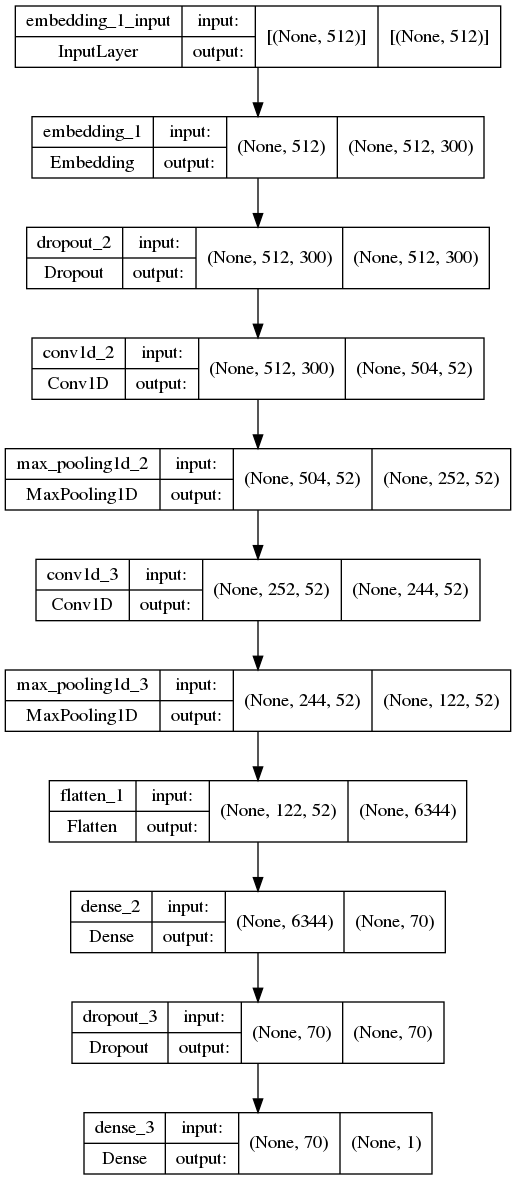

In [11]:
# Plot neural network and store in file

plot_model(best_model_cnn_we, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)

### 3.7.2 Long Short-Term memory (LSTM)<a class="anchor" id="section_3_7_2"></a>

- Type of recurrent neural network that is better in terms of memory;
- Holds the required information and discard the information which is not required or useful for further prediction. 


In [9]:
# Model

def create_lstm_model_for_tuning(hp):
    model_lstm_we = Sequential()

    # Add layers
    model_lstm_we.add(Embedding(vocabulary_length, 300, weights=[embedding_matrix], trainable=False, input_length=max_length_content))
    model_lstm_we.add(LSTM(units=hp.Int('units',min_value=32, max_value=512, step=32), activation="sigmoid"))
    model_lstm_we.add(Dense(1, activation="sigmoid")) # binary classification

    model_lstm_we.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model_lstm_we

# IF SAVED - Load saved model
#best_model_lstm_we = pickle.load(open("models/LSTMWE.pickle", 'rb'))

In [10]:
# Hyper-parameteres tuning

tuner = kt.Hyperband(create_lstm_model_for_tuning, objective='val_accuracy', max_epochs=5, factor=3, directory='hp_tuning', project_name='lstm')

tuner.search_space_summary()

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(we_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[stop_early])
best_hp=tuner.get_best_hyperparameters()[0]
best_model_lstm_we = tuner.hypermodel.build(best_hp)

best_model_lstm_we.summary()

Trial 10 Complete [00h 00m 44s]
val_accuracy: 0.7643312215805054

Best val_accuracy So Far: 0.8216560482978821
Total elapsed time: 00h 21m 39s
INFO:tensorflow:Oracle triggered exit


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 300)          15385500  
                                                                 
 lstm_1 (LSTM)               (None, 288)               678528    
                                                                 
 dense_1 (Dense)             (None, 1)                 289       
                                                                 
Total params: 16,064,317
Trainable params: 678,817
Non-trainable params: 15,385,500
_________________________________________________________________


In [11]:
# Model training with BEST hyper-parameteres

best_model_lstm_we.fit(we_train, y_train, batch_size=32, epochs=10)

# Model saving
with open('models/LSTMWE.pickle', 'wb') as f:
    pickle.dump(best_model_lstm_we, f)

# Store evaluation metrics
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=best_model_lstm_we, model_name="Long short-term memory (LSTM)", test_features=we_test, test_labels=y_test, feature_vectorizer_name="Word Embeddings", deep_learning=True)

print("LSTM (Word Embeddings) successfully trained and stored.")

Epoch 1/10
25/25 [==============================] - 72s 3s/step - loss: 0.6605 - accuracy: 0.6176
Epoch 2/10
25/25 [==============================] - 70s 3s/step - loss: 0.5694 - accuracy: 0.7123
Epoch 3/10
25/25 [==============================] - 70s 3s/step - loss: 0.4902 - accuracy: 0.7737
Epoch 4/10
25/25 [==============================] - 70s 3s/step - loss: 0.3989 - accuracy: 0.8235
Epoch 5/10
25/25 [==============================] - 69s 3s/step - loss: 0.3675 - accuracy: 0.8440
Epoch 6/10
25/25 [==============================] - 69s 3s/step - loss: 0.2797 - accuracy: 0.8875
Epoch 7/10
25/25 [==============================] - 69s 3s/step - loss: 0.2552 - accuracy: 0.9015
Epoch 8/10
25/25 [==============================] - 69s 3s/step - loss: 0.2272 - accuracy: 0.9066
Epoch 9/10
25/25 [==============================] - 69s 3s/step - loss: 0.1923 - accuracy: 0.9309
Epoch 10/10
25/25 [==============================] - 70s 3s/step - loss: 0.1663 - accuracy: 0.9361


2022-05-17 19:51:50.256836: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://1f16da4f-437e-48ab-ad1f-31fa52736bda/assets


LSTM (Word Embeddings) successfully trained and stored.


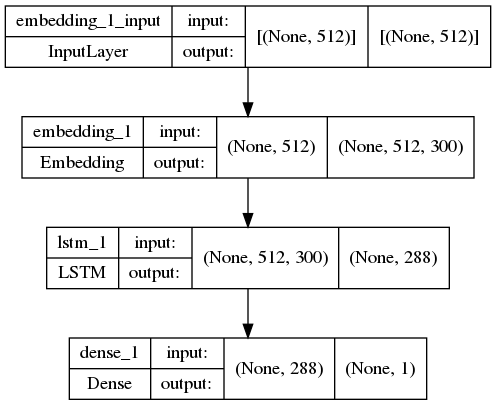

In [12]:
# Plot neural network and store in file

plot_model(best_model_lstm_we, to_file='lstm_plot.png', show_shapes=True, show_layer_names=True)

### 3.7.3 Bidirectional Long short-term memory (Bi-LSTM) <a class="anchor" id="section_3_7_3"></a>

- Bidirection: propagates the input forward and backwards through the RNN layer and then concatenates the final output.

In [13]:
# Model

def create_bilstm_model_for_tuning(hp):
    model_bilstm_we = Sequential()

    # Add layers
    model_bilstm_we.add(Embedding(vocabulary_length, 300, weights=[embedding_matrix], trainable=False, input_length=max_length_content))
    model_bilstm_we.add(Bidirectional(LSTM(units=hp.Int('units',min_value=32, max_value=512, step=32), activation="sigmoid")))
    model_bilstm_we.add(Dense(1, activation="sigmoid")) # binary classification

    model_bilstm_we.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model_bilstm_we

# IF SAVED - Load saved model
#best_model_bilstm_we = pickle.load(open("models/BILSTMWE.pickle", 'rb'))

In [14]:
# Hyper-parameteres tuning

tuner = kt.Hyperband(create_bilstm_model_for_tuning, objective='val_accuracy', max_epochs=5, factor=3, directory='hp_tuning', project_name='bilstm')

tuner.search_space_summary()

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(we_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[stop_early])
best_hp=tuner.get_best_hyperparameters()[0]
best_model_bilstm_we = tuner.hypermodel.build(best_hp)

best_model_bilstm_we.summary()

Trial 10 Complete [00h 16m 50s]
val_accuracy: 0.7006369233131409

Best val_accuracy So Far: 0.7961783409118652
Total elapsed time: 00h 54m 12s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 300)          15385500  
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              186880    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15,572,509
Trainable params: 187,009
Non-trainable params: 15,385,500
_________________________________________________________________


In [15]:
# Model training with BEST hyper-parameteres

best_model_bilstm_we.fit(we_train, y_train, batch_size=32, epochs=10)

# Model saving
with open('models/BILSTMWE.pickle', 'wb') as f:
    pickle.dump(best_model_bilstm_we, f)

# Store evaluation metrics
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=best_model_bilstm_we, model_name="Bidirectional Long short-term memory (Bi-LSTM)", test_features=we_test, test_labels=y_test, feature_vectorizer_name="Word Embeddings", deep_learning=True)

print("Bi-LSTM (Word Embeddings) successfully trained and stored.")

Epoch 1/10
25/25 [==============================] - 21s 674ms/step - loss: 0.6786 - accuracy: 0.5767
Epoch 2/10
25/25 [==============================] - 17s 668ms/step - loss: 0.6138 - accuracy: 0.7199
Epoch 3/10
25/25 [==============================] - 17s 664ms/step - loss: 0.5546 - accuracy: 0.7775
Epoch 4/10
25/25 [==============================] - 17s 666ms/step - loss: 0.4768 - accuracy: 0.8159
Epoch 5/10
25/25 [==============================] - 17s 659ms/step - loss: 0.3672 - accuracy: 0.8593
Epoch 6/10
25/25 [==============================] - 17s 668ms/step - loss: 0.2982 - accuracy: 0.8913
Epoch 7/10
25/25 [==============================] - 17s 662ms/step - loss: 0.3709 - accuracy: 0.8402
Epoch 8/10
25/25 [==============================] - 16s 654ms/step - loss: 0.2628 - accuracy: 0.9015
Epoch 9/10
25/25 [==============================] - 16s 659ms/step - loss: 0.2343 - accuracy: 0.9156
Epoch 10/10
25/25 [==============================] - 16s 653ms/step - loss: 0.2068 - accura

INFO:tensorflow:Assets written to: ram://de849967-4975-4b6f-8dbc-8c1e89fb5f51/assets


Bi-LSTM (Word Embeddings) successfully trained and stored.


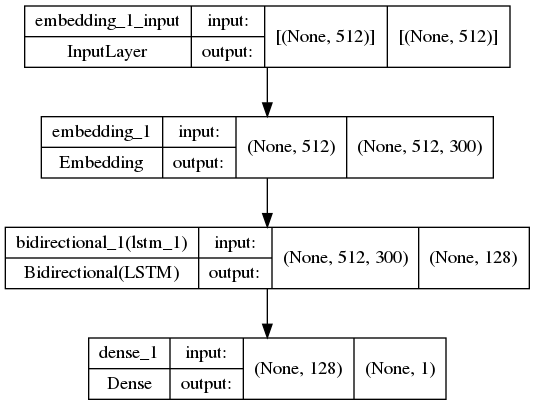

In [16]:
# Plot neural network and store in file

plot_model(best_model_bilstm_we, to_file='bilstm_plot.png', show_shapes=True, show_layer_names=True)

## 3.8 Evaluation analysis <a class="anchor" id="section_3_8"></a>

The final evaluation (with the test dataset) is performed in the optimized models.

In [ ]:
# If not performed previous training and hyper-tuning, Load all saved models and evaluate them

"""
model_lr_bow = pickle.load(open("models/LogisticRegressionBOW.pickle", 'rb'))
model_lr_tfidf = pickle.load(open("models/LogisticRegressionTFIDF.pickle", 'rb'))
model_lr_LIWC = pickle.load(open("models/LogisticRegressionLIWC.pickle", 'rb'))
model_svc_bow = pickle.load(open("models/LinearSVCBOW.pickle", 'rb'))
model_svc_tfidf = pickle.load(open("models/LinearSVCTFIDF.pickle", 'rb'))
model_svc_liwc = pickle.load(open("models/LinearSVCLIWC.pickle", 'rb'))
model_nb_bow = pickle.load(open("models/MultinomialNaiveBayesBOW.pickle", 'rb'))
model_nb_tfidf = pickle.load(open("models/MultinomialNaiveBayesTFIDF.pickle", 'rb'))
model_nb_liwc = pickle.load(open("models/MultinomialNaiveBayesLIWC.pickle", 'rb'))
model_knn_bow = pickle.load(open("models/KNNBOW.pickle", 'rb'))
model_knn_tfidf = pickle.load(open("models/KNNTFIDF.pickle", 'rb'))
model_knn_liwc = pickle.load(open("models/KNNLIWC.pickle", 'rb'))
model_rf_bow = pickle.load(open("models/RandomForestBOW.pickle", 'rb'))
model_rf_tfidf = pickle.load(open("models/RandomForestTFIDF.pickle", 'rb'))
model_rf_liwc = pickle.load(open("models/RandomForestLIWC.pickle", 'rb'))
model_xgb_bow = pickle.load(open("models/XGBoostBOW.pickle", 'rb'))
model_xgb_tfidf = pickle.load(open("models/XGBoostTFIDF.pickle", 'rb'))
model_xgb_liwc = pickle.load(open("models/XGBoostLIWC.pickle", 'rb'))
best_model_cnn_we = pickle.load(open("models/CNNWE.pickle", 'rb'))
best_model_lstm_we = pickle.load(open("models/LSTMWE.pickle", 'rb'))
best_model_bilstm_we = pickle.load(open("models/BILSTMWE.pickle", 'rb'))

evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_lr_bow, model_name="Logistic Regression", test_features=bow_test, test_labels=y_test, feature_vectorizer_name="Bag-of-words")
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_lr_tfidf, model_name="Logistic Regression", test_features=tfidf_test, test_labels=y_test, feature_vectorizer_name="TF-IDF")
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_lr_liwc, model_name="Logistic Regression", test_features=liwc_test, test_labels=y_test, feature_vectorizer_name="LIWC")
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_svc_bow, model_name="Support Vector Classifier (Linear)", test_features=bow_test, test_labels=y_test, feature_vectorizer_name="Bag-of-words")
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_svc_tfidf, model_name="Support Vector Classifier (Linear)", test_features=tfidf_test, test_labels=y_test, feature_vectorizer_name="TF-IDF")
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_svc_liwc, model_name="Support Vector Classifier (Linear)", test_features=liwc_test, test_labels=y_test, feature_vectorizer_name="LIWC")
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_nb_bow, model_name="Naive Bayes (Multinomial)", test_features=bow_test, test_labels=y_test, feature_vectorizer_name="Bag-of-words")
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_nb_tfidf, model_name="Naive Bayes (Multinomial)", test_features=tfidf_test, test_labels=y_test, feature_vectorizer_name="TF-IDF")
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_nb_liwc, model_name="Naive Bayes (Multinomial)", test_features=liwc_test, test_labels=y_test, feature_vectorizer_name="LIWC")
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_knn_bow, model_name="K-Nearest Neighbors", test_features=bow_test, test_labels=y_test, feature_vectorizer_name="Bag-of-words")
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_knn_tfidf, model_name="K-Nearest Neighbors", test_features=tfidf_test, test_labels=y_test, feature_vectorizer_name="TF-IDF")
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_knn_liwc, model_name="K-Nearest Neighbors", test_features=liwc_test, test_labels=y_test, feature_vectorizer_name="LIWC")
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_rf_bow, model_name="Random Forest", test_features=bow_test, test_labels=y_test, feature_vectorizer_name="Bag-of-words")
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_rf_tfidf, model_name="Random Forest", test_features=tfidf_test, test_labels=y_test, feature_vectorizer_name="TF-IDF")
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_rf_liwc, model_name="Random Forest", test_features=liwc_test, test_labels=y_test, feature_vectorizer_name="LIWC")
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_xgb_bow, model_name="XGBoost", test_features=bow_test, test_labels=y_test, feature_vectorizer_name="Bag-of-words")
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_xgb_tfidf, model_name="XGBoost", test_features=tfidf_test, test_labels=y_test, feature_vectorizer_name="TF-IDF")
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=model_xgb_liwc, model_name="XGBoost", test_features=liwc_test, test_labels=y_test, feature_vectorizer_name="LIWC")
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=best_model_cnn_we, model_name="Convolutional Neural Network", test_features=we_test, test_labels=y_test, feature_vectorizer_name="Word Embeddings", deep_learning=True)
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=best_model_lstm_we, model_name="Long short-term memory (LSTM)", test_features=we_test, test_labels=y_test, feature_vectorizer_name="Word Embeddings", deep_learning=True)
evaluation_metrics = evaluation(evaluation_metrics_list=evaluation_metrics, model=best_model_bilstm_we, model_name="Bidirectional Long short-term memory (Bi-LSTM)", test_features=we_test, test_labels=y_test, feature_vectorizer_name="Word Embeddings", deep_learning=True)
"""

In [46]:
# Print evalution 

evaluation = pd.DataFrame(data=evaluation_metrics)
evaluation.columns = ['Model', 'Feature Vectorizer', 'Accuracy', 'Precision', 'Recall', 'F1']
evaluation = evaluation.sort_values(by='Accuracy', ascending=False)
evaluation

,Model,Feature Vectorizer,Accuracy,Precision,Recall,F1
7,Naive Bayes (Multinomial),TF-IDF,94.39,0.925,0.971,0.947
1,Logistic Regression,TF-IDF,93.37,0.932,0.941,0.937
13,Random Forest,TF-IDF,92.86,0.900,0.971,0.934
0,Logistic Regression,Bag-of-words,91.84,0.922,0.922,0.922
19,Long short-term memory (LSTM),Word Embeddings,91.33,0.890,0.951,0.919
4,Support Vector Classifier (Linear),TF-IDF,90.82,0.929,0.892,0.910
18,Convolutional Neural Network,Word Embeddings,90.82,0.967,0.853,0.906
12,Random Forest,Bag-of-words,90.82,0.875,0.961,0.916
3,Support Vector Classifier (Linear),Bag-of-words,90.31,0.919,0.892,0.905
20,Bidirectional Long short-term memory (Bi-LSTM),Word Embeddings,89.29,0.926,0.863,0.893
